In [1]:
from tensorflow.keras.datasets import cifar10

In [2]:
import tensorflow as tf

In [3]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [4]:
from tensorflow.keras.applications import VGG16

In [5]:
conv_base=VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [7]:
from tensorflow.keras import models,layers

In [8]:
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dense(10,activation="softmax"))

In [9]:
from tensorflow.keras.utils import to_categorical

In [10]:
y_train=to_categorical(y_train)

In [11]:
x_val=x_train[:15000]
y_val=y_train[:15000]
partial_x_train=x_train[15000:]
partial_y_train=y_train[15000:]

In [20]:
conv_base.trainable=False
def fine_tunning():
    for layers in conv_base.layers:
        if layers.name=="block5_conv1":
            layers.trainable=True
        else:
            layers.trainable=False

In [19]:
model.compile(optimizer="Nadam",loss="categorical_crossentropy",metrics=["acc"])

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_dir=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,rotation_range=90)
val_dir=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,rotation_range=180)

In [17]:
train=train_dir.flow(partial_x_train,partial_y_train,batch_size=350)
val=val_dir.flow(x_val,y_val,batch_size=300)

In [21]:
with tf.device("/gpu:0"):
    history=model.fit_generator(train,epochs=30,steps_per_epoch=100,validation_data=val,validation_steps=50)

Epoch 1/30
100/100 [==============================] - 217s 2s/step - loss: 1.7417 - acc: 0.3832 - val_loss: 1.5706 - val_acc: 0.4490
Epoch 2/30
100/100 [==============================] - 217s 2s/step - loss: 1.6078 - acc: 0.4360 - val_loss: 1.5057 - val_acc: 0.4739
Epoch 3/30
100/100 [==============================] - 221s 2s/step - loss: 1.5577 - acc: 0.4516 - val_loss: 1.4772 - val_acc: 0.4831
Epoch 4/30
100/100 [==============================] - 219s 2s/step - loss: 1.5421 - acc: 0.4581 - val_loss: 1.4656 - val_acc: 0.4879
Epoch 5/30
100/100 [==============================] - 216s 2s/step - loss: 1.5207 - acc: 0.4663 - val_loss: 1.4613 - val_acc: 0.4901
Epoch 6/30
100/100 [==============================] - 216s 2s/step - loss: 1.5226 - acc: 0.4672 - val_loss: 1.4515 - val_acc: 0.4923
Epoch 7/30
100/100 [==============================] - 216s 2s/step - loss: 1.5059 - acc: 0.4698 - val_loss: 1.4509 - val_acc: 0.4895
Epoch 8/30
100/100 [==============================] - 216s 2s/step - 

In [22]:
model.save("vgg16_fine.h5")

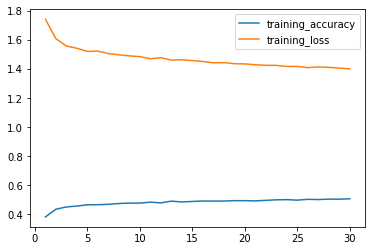

In [25]:
import matplotlib.pyplot as plt
data=history.history
plt.plot(range(1,31),data['acc'],label="training_accuracy")
plt.plot(range(1,31),data['loss'],label="training_loss")
plt.legend()

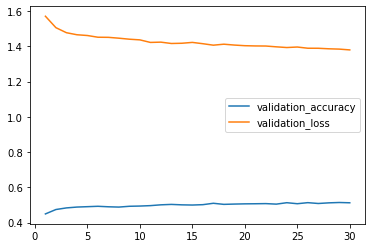

In [26]:
plt.plot(range(1,31),data['val_acc'],label="validation_accuracy")
plt.plot(range(1,31),data['val_loss'],label="validation_loss")
plt.legend()

In [59]:
layers_output=[layers.output for layers in conv_base.layers[:8]]
activation_model=models.Model(inputs=conv_base.input,outputs=layers_output)

In [60]:
x=x_train[0]
activation_model_output=activation_model.predict(x)

In [75]:
output_first=activation_model_output[7]

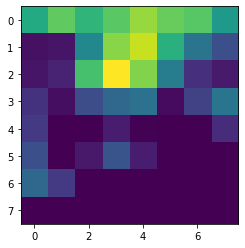

In [79]:
plt.imshow(output_first[0,:,:,7],interpolation="nearest")

In [57]:
layers_output

[<tf.Tensor 'input_1:0' shape=(None, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'block1_conv1/Identity:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'block1_conv2/Identity:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'block1_pool/Identity:0' shape=(None, 16, 16, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Identity:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'block2_conv2/Identity:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'block2_pool/Identity:0' shape=(None, 8, 8, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Identity:0' shape=(None, 8, 8, 256) dtype=float32>]

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 14,748,170
Trainable params: 33,482
Non-trainable params: 14,714,688
_________________________________________________________________
